In [1]:
import pytesseract
from PIL import Image
# psm is an important param, learn how to set it with the link below
# https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/
# oem is another important param, ranged 0-3. start with 3 and if not good, try the rest
custom_config = r'--oem 3 --psm 6'
image_path = "./invoice-template-us-dexter-750px.png"
extracted_data = pytesseract.image_to_data(Image.open(image_path), lang='eng', config=custom_config, output_type=pytesseract.Output.DICT)

In [2]:
# Set confidence threshold (e.g., 70%)
conf_threshold = 70

# Reconstruct the string output while skipping low-confidence words
filtered_text = []
current_line = []
prev_block_num = -1
prev_line_num = -1

for i in range(len(extracted_data["text"])):
    text = extracted_data["text"][i].strip()
    conf = float(extracted_data["conf"][i])
    block_num = extracted_data["block_num"][i]
    line_num = extracted_data["line_num"][i]
    
    # Skip if:
    # 1. Empty text OR
    # 2. Confidence below threshold OR
    # 3. Confidence is -1 (Tesseract's "non-text" marker)
    if not text or conf < conf_threshold or conf == -1:
        continue
    
    # Handle line breaks (Tesseract's line/block tracking)
    if block_num != prev_block_num or line_num != prev_line_num:
        if current_line:  # Join words in the current line
            filtered_text.append(" ".join(current_line))
            current_line = []
        prev_block_num = block_num
        prev_line_num = line_num
    
    current_line.append(text)

# Add the last line if it exists
if current_line:
    filtered_text.append(" ".join(current_line))

# Join all lines with newlines (mimicking image_to_string output)
final_output = "\n".join(filtered_text)

print("Filtered text (confidence >= {}):\n{}".format(conf_threshold, final_output))

Filtered text (confidence >= 70):
st Repair Inc.
1912 Harvest Lane
New York, NY 12210
BILLTO INVOICE #
John Smith John Smith INVOICE DATE 1102/2019
Court Square 3787 Pineview Drive
lew York, NY 12210 Cambridge, MA 12210 4 2312/2019
DATE
DESCRIPTION UNIT PRICE
Front and rear brake cables 100.00
New set of pedal arms 15.00 30.00
Labor 3hrs 5.00 15.00
‘Subtotal 145.00
Sales Tax 6.25% 9.08
TOTAL $154.06
& CONDITIONS
due within 15 days
checks payable to: East Repair Inc.


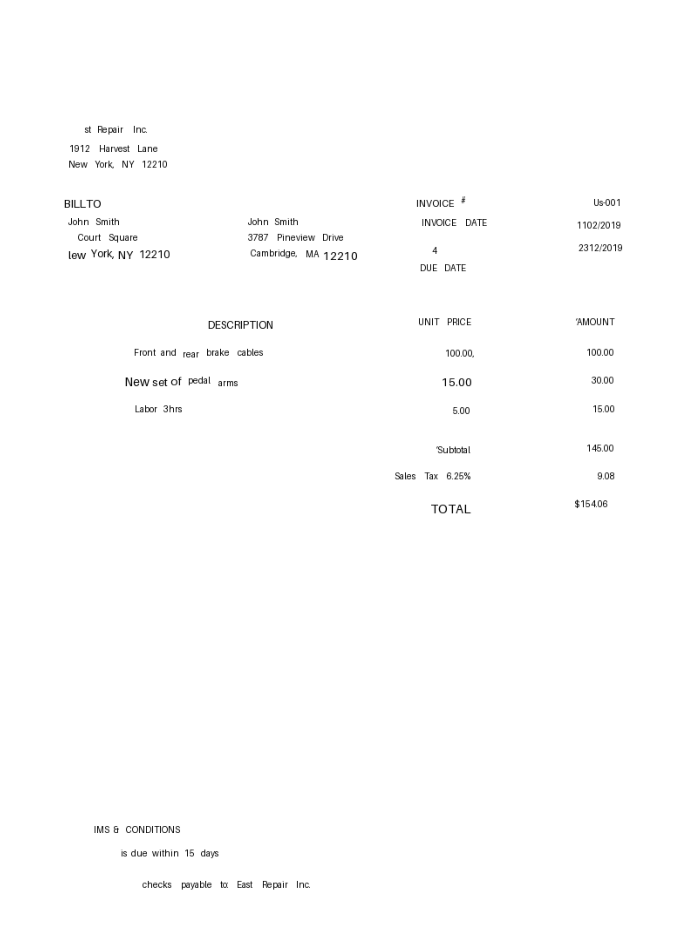

In [5]:
from PIL import ImageDraw, ImageFont

# Create a white background image (adjust size as needed)
with Image.open(image_path) as img:
    img_width, img_height = img.size

# Create a white background image with same dimensions as original
img = Image.new('RGB', (img_width, img_height), (255, 255, 255))
draw = ImageDraw.Draw(img)

# Load font
# you can download from https://github.com/PaddlePaddle/PaddleOCR/tree/main/doc/fonts
font_path = None # if None, it will use default

for i in range(len(extracted_data['text'])):
    text = extracted_data['text'][i]
    if not text:  # Skip empty text
        continue
    conf = extracted_data['conf'][i]
    if conf <50:
        continue
    
    # Get the bounding box coordinates
    x_min, y_min = extracted_data['left'][i], extracted_data['top'][i]
    
    # Calculate text width and height
    text_width = extracted_data['width'][i]
    text_height = extracted_data['height'][i]
    
    # Calculate font size based on text height
    font_size = int((text_height + text_width/len(text))*0.35)  # Adjust factor as needed

    if font_size < 10:
        font_size = 10  # Minimum font size
    if font_size > 200:
        font_size = 200 
    try:
        font = ImageFont.truetype(font_path, font_size)
    except:
        font = ImageFont.load_default(size=font_size)
    
    # Calculate text position (centered in the box)
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_w = text_bbox[2] - text_bbox[0]
    text_h = text_bbox[3] - text_bbox[1]
    
    # Calculate position to center text in the box
    x_pos = x_min + (text_width - text_w) // 2
    y_pos = y_min + (text_height - text_h) // 2
    
    # Draw the text
    draw.text((x_pos, y_pos), text, font=font, fill=(0, 0, 0))

# Save or show the image
img.save('output_text.png')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Convert PIL image to numpy array
img_array = np.array(img)

# Display image
plt.figure(figsize=(12, 12))
plt.imshow(img_array)
plt.axis('off')
plt.show()